# Mixtures and MCMC

##### Keywords: supervised learning, semi-supervised learning, unsupervised learning, mixture model, gaussian mixture model, pymc3, label-switching, identifiability, normal distribution, pymc3 potentials

We now do a study of learning mixture models with MCMC. We have already done this in the case of the Zero-Inflated Poisson Model, and will stick to Gaussian Mixture models for now.

In [5]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm
import theano.tensor as tt

## Mixture of 2 Gaussians, the old faithful data

We start by considering waiting times from the Old-Faithful Geyser at Yellowstone National Park.

In [6]:
ofdata=pd.read_csv("data/oldfaithful.csv")
ofdata.head()

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


//anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
//anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)
//anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


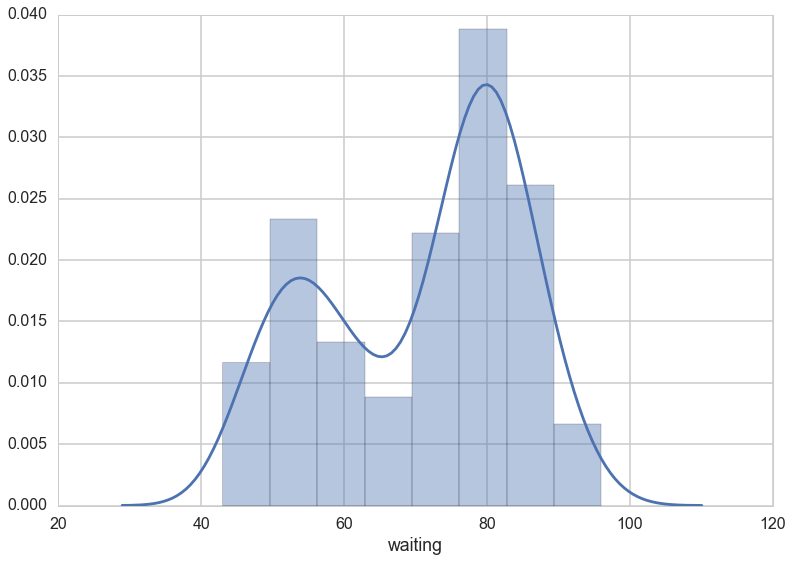

In [7]:
sns.distplot(ofdata.waiting);

Visually, there seem to be two components to the waiting time, so let us model this using a mixture of two gaussians. Remember that this is a unsupervized model, and all we are doing is modelling $p(x)$ , with the assumption that there are two clusters and a hidden variable $z$ that indexes them.

In [8]:
with pm.Model() as ofmodel:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    assignment = pm.Categorical("assignment", p, 
                                shape=ofdata.shape[0])
    sds = pm.Uniform("sds", 0, 100, shape=2)
    centers = pm.Normal("centers", 
                        mu=np.array([50, 80]), 
                        sd=np.array([20, 20]), 
                        shape=2)
    
    # and to combine it with the observations:
    observations = pm.Normal("obs", mu=centers[assignment], sd=sds[assignment], observed=ofdata.waiting)

In [9]:
with ofmodel:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.ElemwiseCategorical(vars=[assignment])
    oftrace_full = pm.sample(10000, step=[step1, step2], njobs=2)

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  app.launch_new_instance()
//anaconda/envs/py35/lib/python3.5/site-packages/pymc3/sampling.py:163: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
100%|██████████| 10000/10000 [01:18<00:00, 128.16it/s]


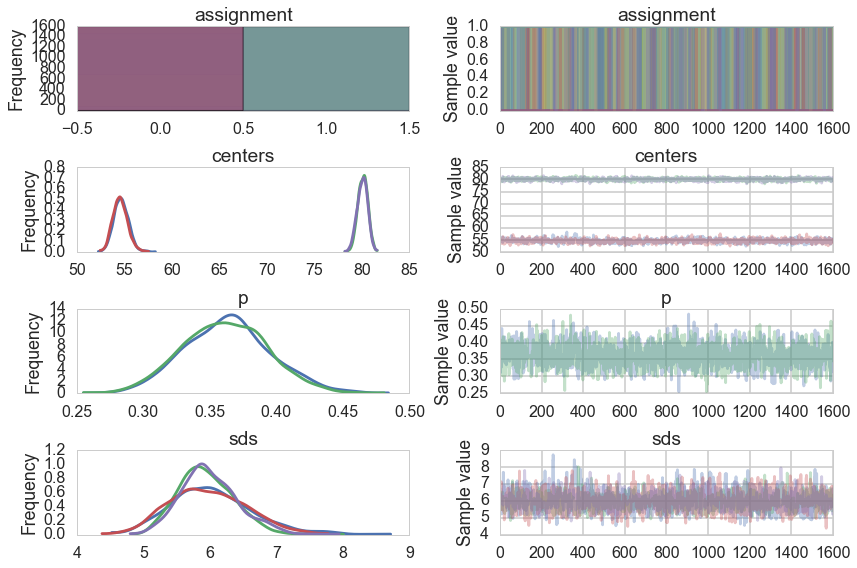

In [11]:
oftrace = oftrace_full[2000::5]
pm.traceplot(oftrace);

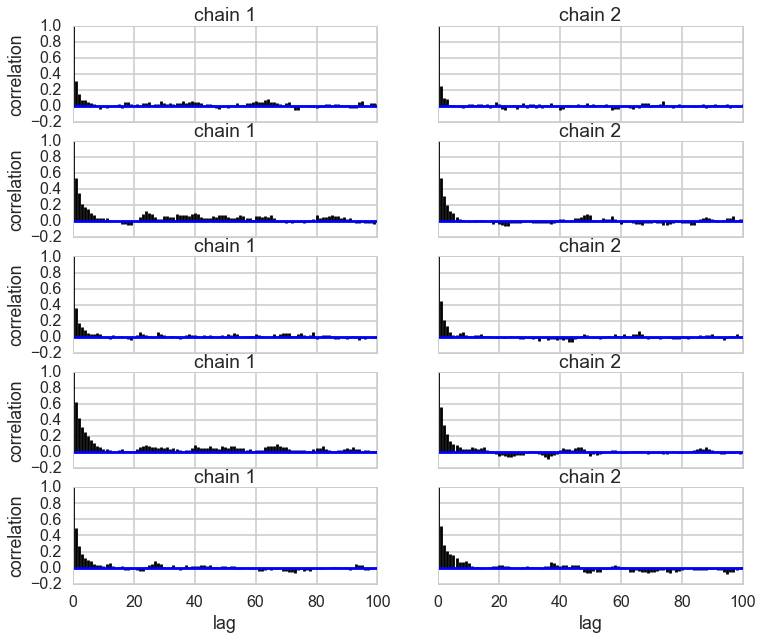

In [12]:
pm.autocorrplot(oftrace, varnames=['p', 'centers', 'sds']);

In [13]:
oftrace['centers'].mean(axis=0)

array([ 54.6205673 ,  80.06732802])

We can visualize the two clusters, suitably scales by the category-belonging probability by taking the posterior means. Note that this misses any smearing that might go into making the posterior predictive

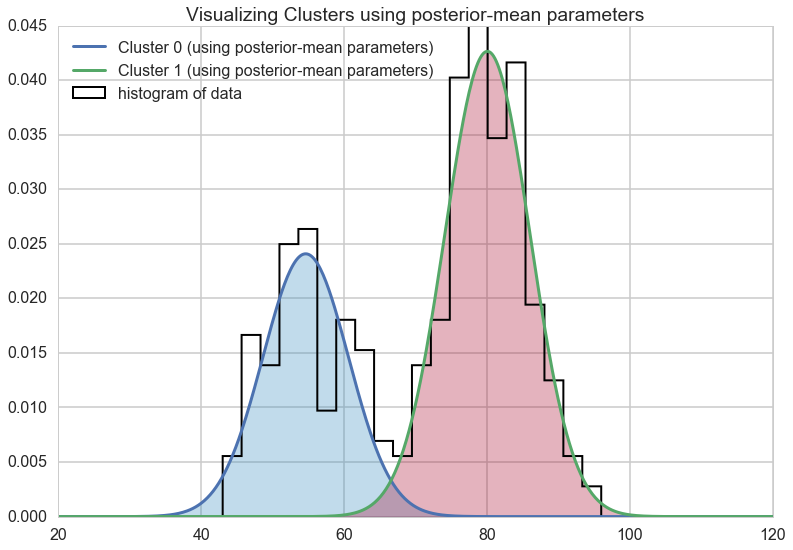

In [16]:
from scipy.stats import norm
x = np.linspace(20, 120, 500)
# for pretty colors later in the book.
colors = ["#348ABD", "#A60628"] if oftrace['centers'][-1, 0] > oftrace['centers'][-1, 1] \
    else ["#A60628", "#348ABD"]

posterior_center_means = oftrace['centers'].mean(axis=0)
posterior_std_means = oftrace['sds'].mean(axis=0)
posterior_p_mean = oftrace["p"].mean()

plt.hist(ofdata.waiting, bins=20, histtype="step", normed=True, color="k",
     lw=2, label="histogram of data")
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");

## A tetchy 3 Gaussian Model

Let us set up our data.

//anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


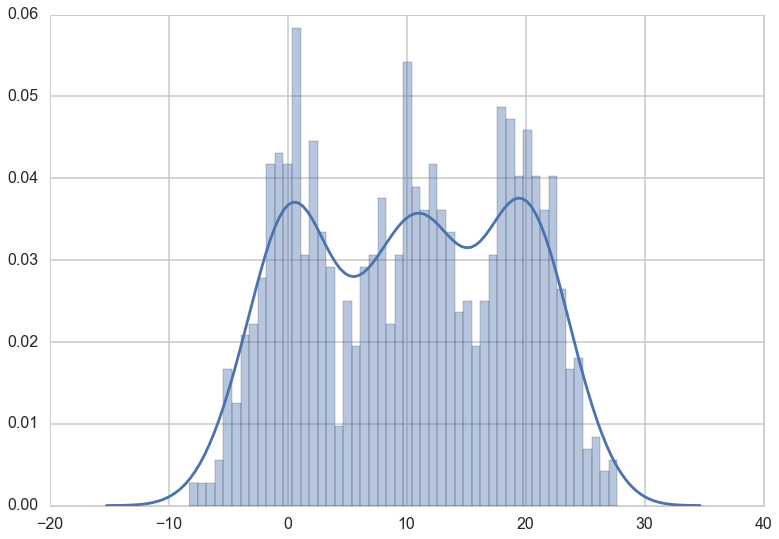

In [116]:
mu_true = np.array([0, 10, 20])
sigma_true = np.array([3, 3, 3])
lambda_true = np.array([.33, .33, .34])
n = 1000
from scipy.stats import multinomial
# Simulate from each distribution according to mixing proportion psi
z = multinomial.rvs(1, lambda_true, size=n)
data=np.array([np.random.normal(mu_true[i.astype('bool')][0], sigma_true[i.astype('bool')][0]) for i in z])
sns.distplot(data, bins=50);

In [132]:
np.savetxt("data/3g.dat", data)

In a similar way to before, we set up our sampling. The main difference is the direct use of the Dirichlet as a prior.

In [117]:
with pm.Model() as mof:
    p = pm.Dirichlet('p', a=np.array([1., 1., 1.]), shape=3)


    # cluster centers
    means = pm.Normal('means', mu=[0,10,20], sd=5, shape=3)


    sds = pm.Uniform('sds', lower=0, upper=20, shape=3)

    # latent cluster of each observation
    category = pm.Categorical('category',
                              p=p,
                              shape=data.shape[0])

    # likelihood for each observed value
    points = pm.Normal('obs',
                       mu=means[category],
                       sd=sds[category],
                       observed=data)


In [118]:
with mof:
    step1 = pm.Metropolis(vars=[p, sds, means])
    step2 = pm.ElemwiseCategorical(vars=[category])
    tripletrace_full = pm.sample(10000, step=[step1, step2], njobs=2)

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  app.launch_new_instance()
//anaconda/envs/py35/lib/python3.5/site-packages/pymc3/sampling.py:163: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
100%|██████████| 10000/10000 [03:10<00:00, 61.94it/s]


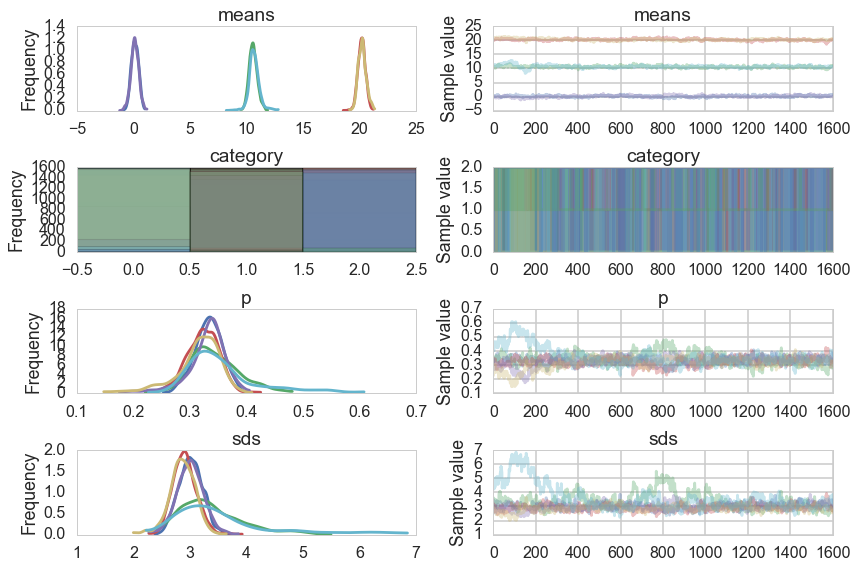

In [119]:
trace_mof=tripletrace_full[2000::5]
pm.traceplot(trace_mof);

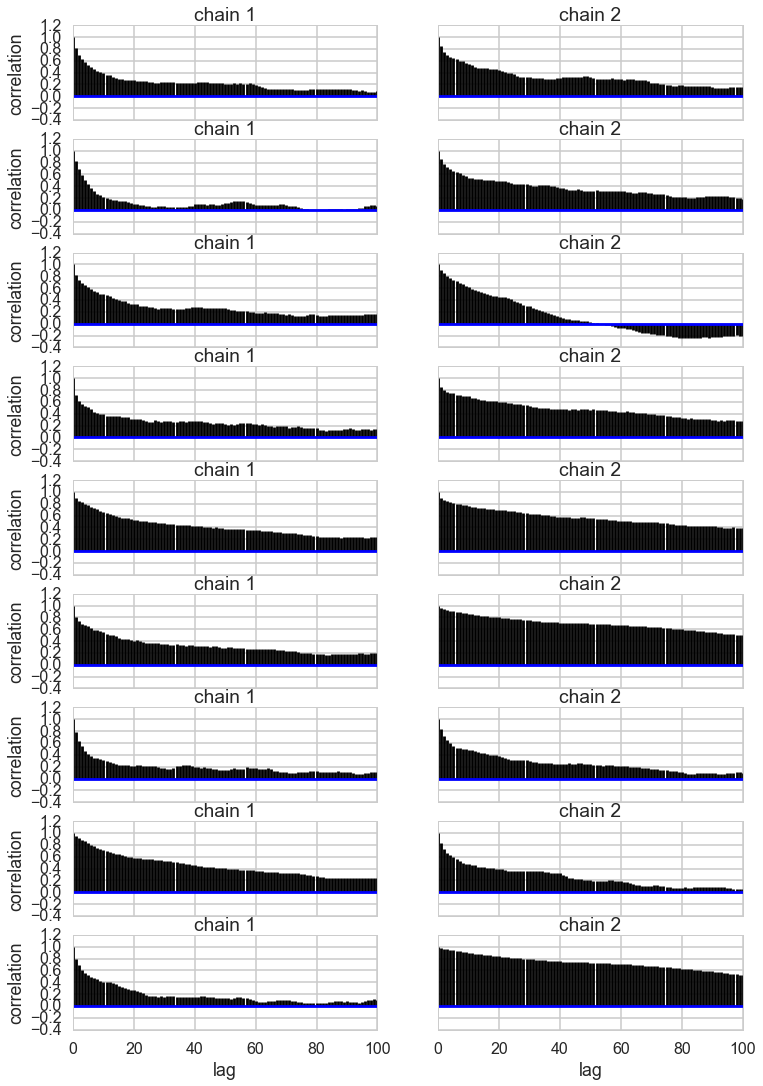

In [120]:
pm.autocorrplot(trace_mof, varnames=['means', 'p', 'sds']);

## Problems with clusters and sampling

Some of the traces seem ok, but the autocorrelation is quite bad. This is because there are major problems with using MCMC for clustering.

These are firstly, the lack of parameter identifiability (the so called label-switching problem) and secondly, the multimodality of the posteriors.

We have seen non-identifiability before. Switching labels on the means and z's, for example, does not change the likelihoods. The problem with this is that cluster parameters cannot be compared across chains: what might be a cluster parameter in one chain could well belong to the other cluster in the second chain. Even within a single chain, indices might swam leading to a tell tale back and forth in the traces for long chains or data not cleanly separated.

Also, the (joint) posteriors can be highly multimodal. One form of multimodality is the non-identifiability, though even without identifiability issues the posteriors are highly multimodal.

To quote the Stan manual:
>Bayesian inference fails in cases of high multimodality because there is no way to visit all of the modes in the posterior in appropriate proportions and thus no way to evaluate integrals involved in posterior predictive inference.
In light of these two problems, the advice often given in fitting clustering models is to try many different initializations and select the sample with the highest overall probability. It is also popular to use optimization-based point estimators such as expectation maximization or variational Bayes, which can be much more efficient than sampling-based approaches.

In [121]:
trace_mof['category'].mean()

1.0099968749999999

### Some mitigation via potentials in pymc3

The idea behinf a `Potential` is something that is not part of the likelihood, but enforces a constraint by setting the probability to 0 if the constraint is violated. We use it here to give each cluster some membership and to order the means to remove the non-identifiability problem. See below for how its used.

But this is not a panacea. Sampling is still vety hard.


In [122]:
import theano.tensor as tt
with pm.Model() as mof2:
    p = pm.Dirichlet('p', a=np.array([1., 1., 1.]), shape=3)
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))

    # cluster centers
    means = pm.Normal('means', mu=[0, 10, 20], sd=5, shape=3)

    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)
                                         + tt.switch(means[2]-means[1] < 0, -np.inf, 0))
                                         
    # measurement error
    sds = pm.Uniform('sds', lower=0, upper=20, shape=3)

    # latent cluster of each observation
    category = pm.Categorical('category',
                              p=p,
                              shape=data.shape[0])

    # likelihood for each observed value
    points = pm.Normal('obs',
                       mu=means[category],
                       sd=sds[category],
                       observed=data)


In [123]:
with mof2:
    step1 = pm.Metropolis(vars=[p, sds, means])
    step2 = pm.ElemwiseCategorical(vars=[category])
    tripletrace_full2 = pm.sample(10000, step=[step1, step2], njobs=2)

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  app.launch_new_instance()
//anaconda/envs/py35/lib/python3.5/site-packages/pymc3/sampling.py:163: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
100%|██████████| 10000/10000 [02:57<00:00, 56.23it/s]


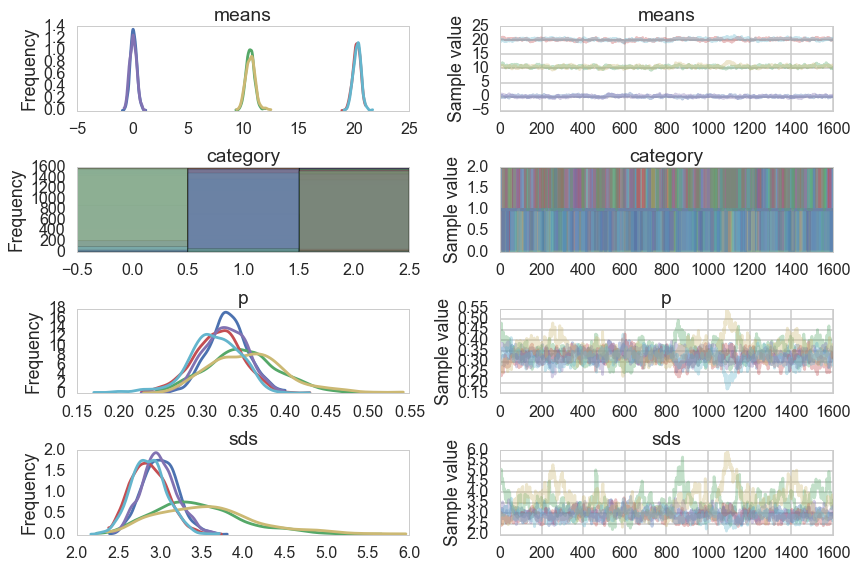

In [124]:
trace_mof2 = tripletrace_full2[2000::5]
pm.traceplot(trace_mof2);

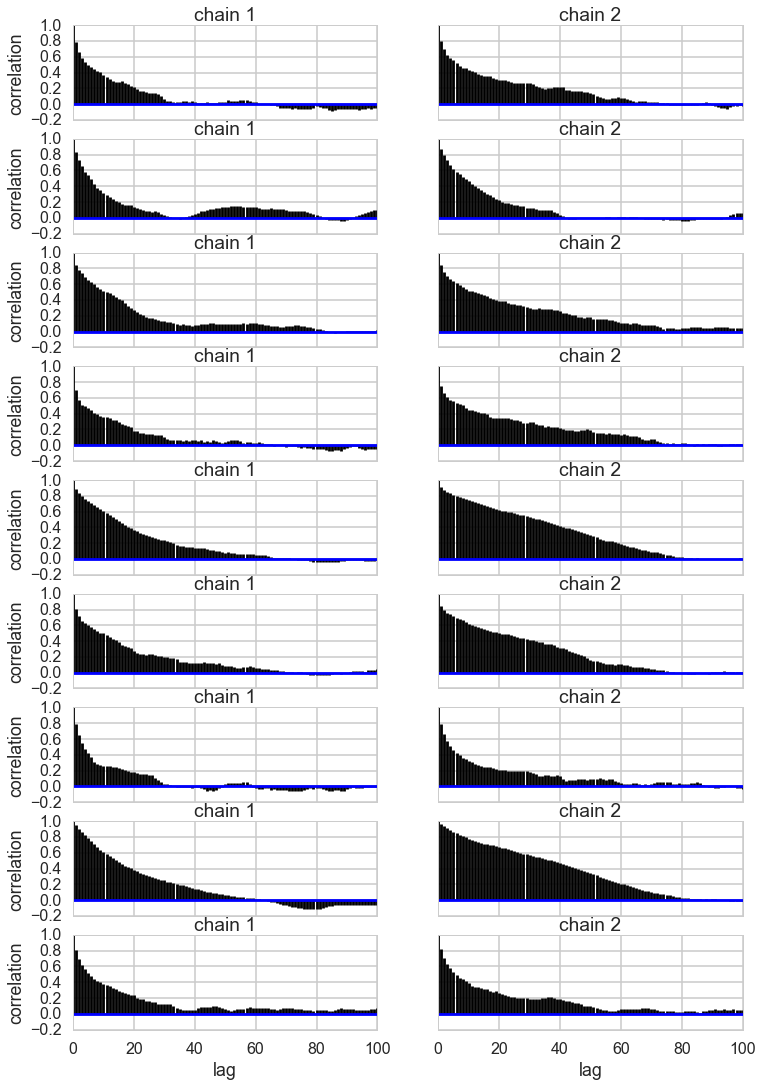

In [125]:
pm.autocorrplot(trace_mof2, varnames=["means", "p", "sds"]);

In [126]:
with mof2:
    step1 = pm.Metropolis(vars=[p, sds, means])
    step2 = pm.ElemwiseCategorical(vars=[category])
    trace_mof_big = pm.sample(20000, step=[step1, step2], trace=tripletrace_full2, njobs=2)

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  app.launch_new_instance()
//anaconda/envs/py35/lib/python3.5/site-packages/pymc3/sampling.py:163: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
100%|██████████| 20000/20000 [06:17<00:00, 53.02it/s]


In [127]:
len(trace_mof_big), trace_mof_big['means'].shape

(30000, (60000, 3))

In [128]:
trace_mof21 = trace_mof_big[3000::10]
trace_mof21['means'].shape

(5400, 3)

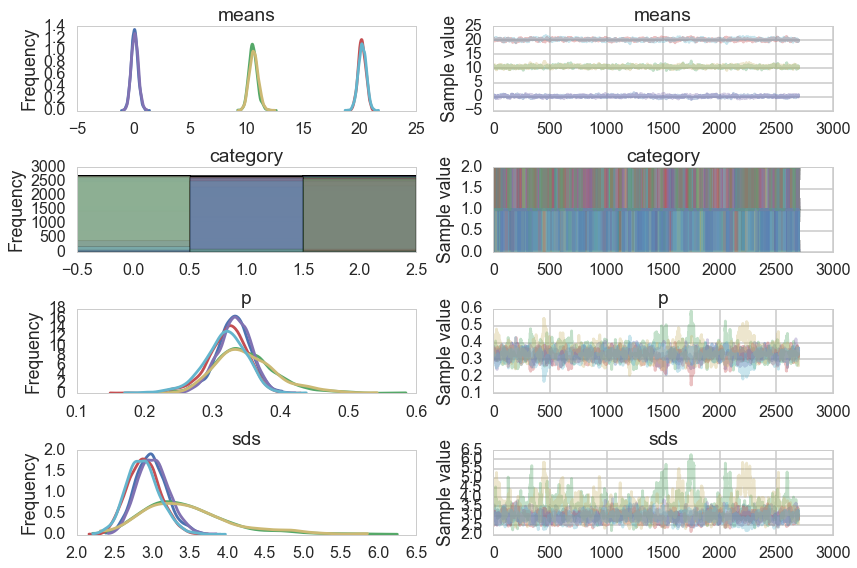

In [129]:
pm.traceplot(trace_mof21);

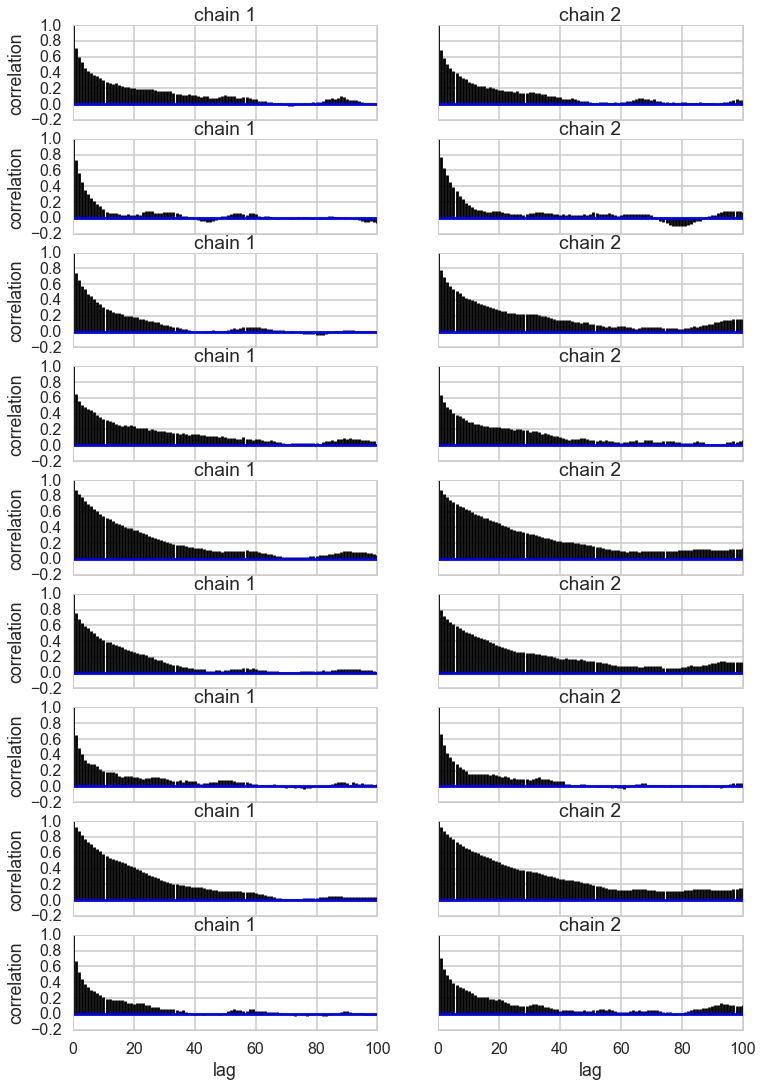

In [130]:
pm.autocorrplot(trace_mof21, varnames=["means", "p", "sds"]);

We do much better now

## Supervised and semi-supervised Learning

In other notes, we used mixture models to categorize the various types of learning. The key difference was how we wrote the likelihoods. Lets use those likelihoods to untertake sampling in supervised and semi-supervised ways. We have already seen unsupervised sampling

We'll use the heights-weights data set as we do have a story for why these outght to be separately gaussianly distributed for men and women.

In [22]:
df=pd.read_csv("data/01_heights_weights_genders.csv")
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [23]:
df.describe()

,Height,Weight
count,10000.000000,10000.000000
mean,66.367560,161.440357
std,3.847528,32.108439
min,54.263133,64.700127
25%,63.505620,135.818051
50%,66.318070,161.212928
75%,69.174262,187.169525
max,78.998742,269.989699


A KDEplot confirms our intuition


Exception in thread Thread-8:
Traceback (most recent call last):
  File "//anaconda/envs/py35/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "//anaconda/envs/py35/lib/python3.5/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "//anaconda/envs/py35/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



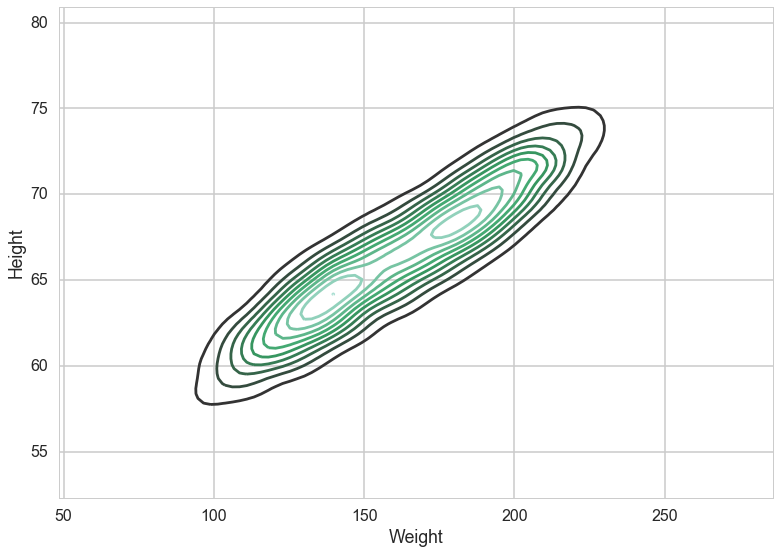

In [24]:
sns.kdeplot(df.Weight, df.Height)

To keep things simple, we'll keep to one dimension by sticking with the weight marginal. Plotting it, there definitely seems to be a double humped distribution:

//anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


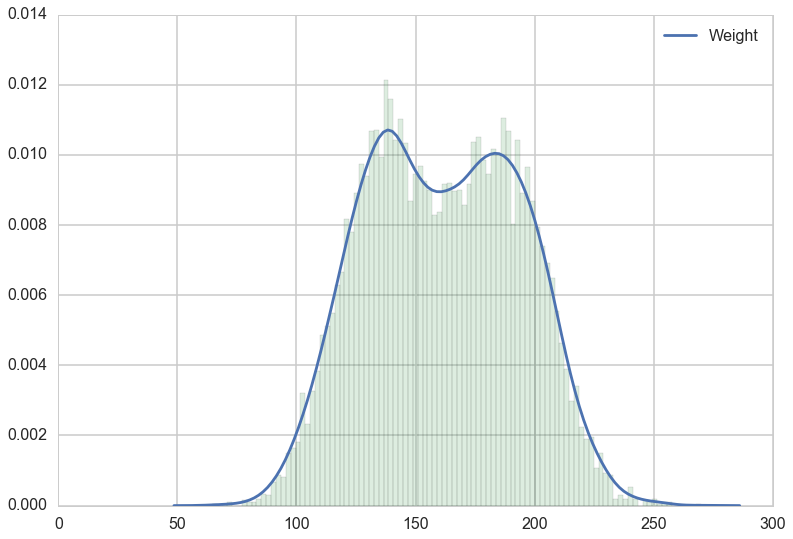

In [25]:
sns.kdeplot(df.Weight)
plt.hist(df.Weight, bins=100, alpha=0.2, normed=True);

We do the train-test split. Notice we will keep a very small number of points in the training set.

In [26]:
makesmall=np.random.choice(range(df.shape[0]), size=500, replace=False)
datax=df.Weight.values
dataz=1*(df.Gender=='Male')
datax=datax[makesmall]
dataz=dataz.values[makesmall]
from sklearn.cross_validation import train_test_split
itr, ite = train_test_split(range(dataz.shape[0]), train_size=0.05, stratify=dataz)
xte=datax[ite]
xtr=datax[itr]
zte=dataz[ite]
ztr=dataz[itr]


//anaconda/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [27]:
zte.shape, zte.mean(), ztr.mean(), ztr.shape

((475,), 0.50736842105263158, 0.52000000000000002, (25,))

We use 2-D categoricals to make cluster assignments. Notice that these training assignments are also observed stochastics now, in addition to the $x$. 

In [28]:
with pm.Model() as classmodel1:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    assignment_tr = pm.Categorical("assignment_tr", p, 
                                observed=ztr)
    sds = pm.Uniform("sds", 0, 100, shape=2)
    centers = pm.Normal("centers", 
                        mu=np.array([130, 170]), 
                        sd=np.array([20, 20]), 
                        shape=2)
    p_min_potential = pm.Potential('lam_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))
    order_centers_potential = pm.Potential('order_centers_potential',
                                         tt.switch(centers[1]-centers[0] < 0, -np.inf, 0))
    
    # and to combine it with the observations:
    observations = pm.Normal("obs", mu=centers[assignment_tr], sd=sds[assignment_tr], observed=xtr)
    

In [29]:
with classmodel1:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    trace_cm1_full = pm.sample(10000, step=[step1], njobs=2)

//anaconda/envs/py35/lib/python3.5/site-packages/pymc3/sampling.py:163: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 1/10000 [00:00<23:25,  7.11it/s]

  0%|          | 44/10000 [00:00<16:26, 10.09it/s]

  1%|          | 87/10000 [00:00<11:34, 14.27it/s]

  1%|▏         | 148/10000 [00:00<08:08, 20.19it/s]

  2%|▏         | 203/10000 [00:00<05:45, 28.38it/s]

  3%|▎         | 265/10000 [00:00<04:04, 39.76it/s]

  4%|▎         | 356/10000 [00:00<02:52, 55.76it/s]

  5%|▍         | 457/10000 [00:00<02:02, 77.81it/s]

  6%|▌         | 560/10000 [00:00<01:27, 107.67it/s]

  7%|▋         | 655/10000 [00:01<01:03, 146.61it/s]

  8%|▊         | 762/10000 [00:01<00:46, 197.75it/s]

  9%|▊         | 854/10000 [00:01<00:35, 256.77it/s]

  9%|▉         | 944/10000 [00:01<00:28, 31

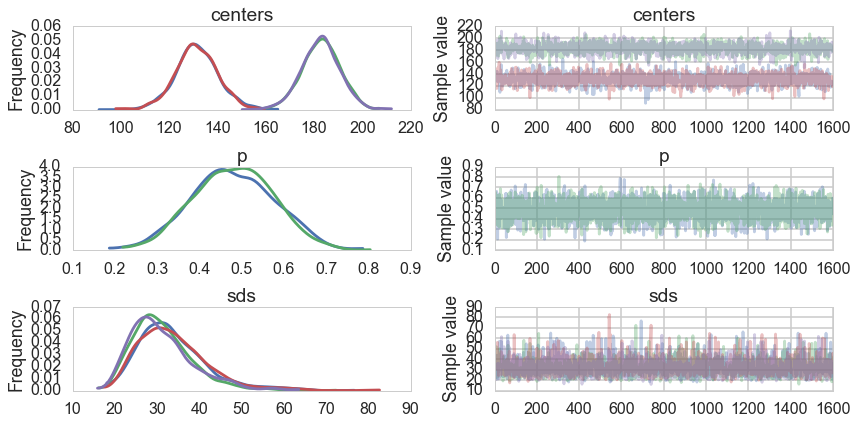

In [30]:
trace_cm1 = trace_cm1_full[2000::5]
pm.traceplot(trace_cm1);

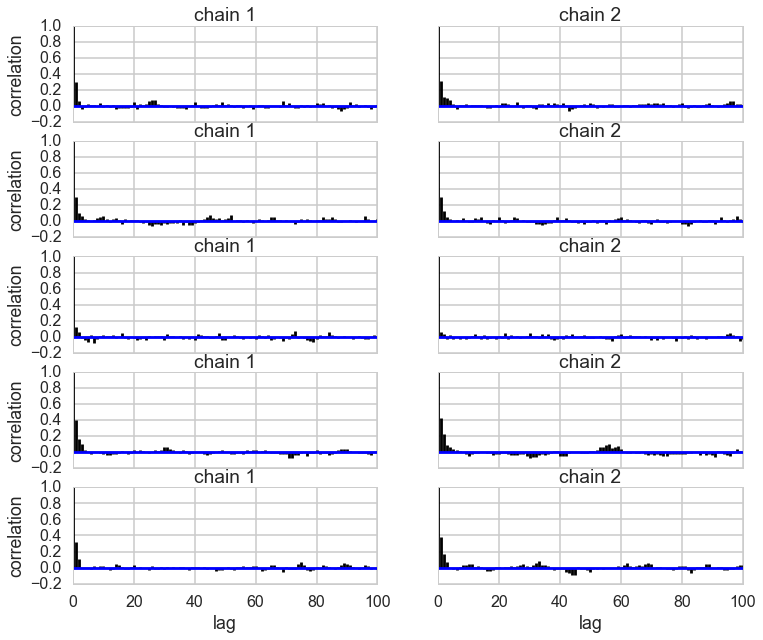

In [31]:
pm.autocorrplot(trace_cm1);

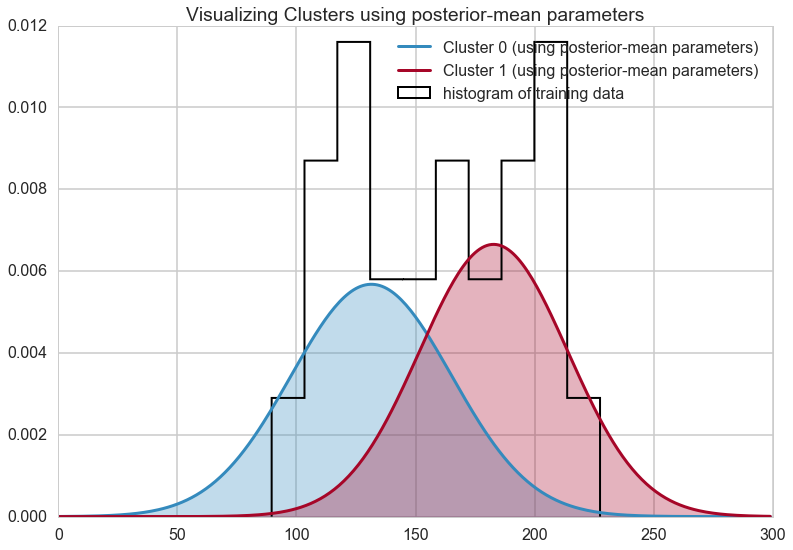

In [36]:
center_trace = trace_cm1["centers"]
std_trace = trace_cm1["sds"]
#identify the clusters
colors = ["#348ABD", "#A60628"] \
if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]
norm = sp.stats.norm
x = np.arange(0, 300, 1)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = 1 - ztr.mean()


y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", color=colors[1], lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", color=colors[0], lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)
plt.hist(xtr, bins=10, histtype="step", normed=True, color="k",
     lw=2, label="histogram of training data")
# plt.hist(xte, bins=20, histtype="step", normed=True, color="k",
#      lw=2, label="histogram of  test data")
plt.legend(loc="upper right")
plt.title("Visualizing Clusters using posterior-mean parameters")

We use the $p(x \vert z)$ to do our classification. What we really want is $p(z \vert x)$, but we can use bayes theorem to inver this, as shown in the diagram below.


![gen and dis](images/bishopgendis.png)



In [37]:
xgivenz0 = lambda x: norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
xgivenz1 = lambda x: norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
zpred1 = 1*(xgivenz1(xte) > xgivenz0(xte))
from sklearn.metrics import confusion_matrix, accuracy_score
confusion_matrix(zte, zpred1)

array([[199,  35],
       [ 12, 229]])

In [38]:
accuracy_score(zte, zpred1)

0.90105263157894733

## Semi-Supervised Learning

In the previous section we did the work on the testing set separately. Here we'd like to model the fact that we have a partial likelihood available for the testing set: we have observed the $x$s, but not the $z$s.

Thus in our model we will include both training and testing $x$s, but only training $z$s as observations, fitting for the testing $z$s.
We now want the trace of the testing assignments. That is we want $p(z \vert x)$ and we'll use the MCMC model to do the whole bayes theorem inversion for us!

In [39]:
with pm.Model() as classmodel2:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    assignment_tr = pm.Categorical("assignment_tr", p, 
                                observed=ztr)
    assignment_te = pm.Categorical("assignment_te", p, 
                                shape=xte.shape[0])
    sds = pm.Uniform("sds", 0, 100, shape=2)
    centers = pm.Normal("centers", 
                        mu=np.array([130, 170]), 
                        sd=np.array([20, 20]), 
                        shape=2)
    p_min_potential = pm.Potential('lam_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))
    order_centers_potential = pm.Potential('order_centers_potential',
                                         tt.switch(centers[1]-centers[0] < 0, -np.inf, 0))
    
    # and to combine it with the observations:
    observations_tr = pm.Normal("obs_tr", mu=centers[assignment_tr], sd=sds[assignment_tr], observed=xtr)
    observations_te = pm.Normal("obs_te", mu=centers[assignment_te], sd=sds[assignment_te], observed=xte)

In [40]:
with classmodel2:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.ElemwiseCategorical(vars=[assignment_te])
    trace_cm2_full = pm.sample(10000, step=[step1, step2], njobs=2)

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  app.launch_new_instance()
//anaconda/envs/py35/lib/python3.5/site-packages/pymc3/sampling.py:163: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 1/10000 [00:00<23:48,  7.00it/s]

  0%|          | 8/10000 [00:00<17:25,  9.56it/s]

  0%|          | 16/10000 [00:00<12:53, 12.91it/s]

  0%|          | 24/10000 [00:00<09:40, 17.17it/s]

  0%|          | 32/10000 [00:00<07:24, 22.40it/s]

  0%|          | 41/10000 [00:00<05:47, 28.65it/s]

  0%|          | 50/10000 [00:00<04:38, 35.73it/s]

  1%|          | 58/10000 [00:00<03:55, 42.14it/s]

  1%|          | 66/10000 [00:01<03:28, 47.72it/s]

  1%|          | 7

Since this is partially an unsupervized scenario, it takes much longer to sample, and we stop sampling even though there is some correlation left over

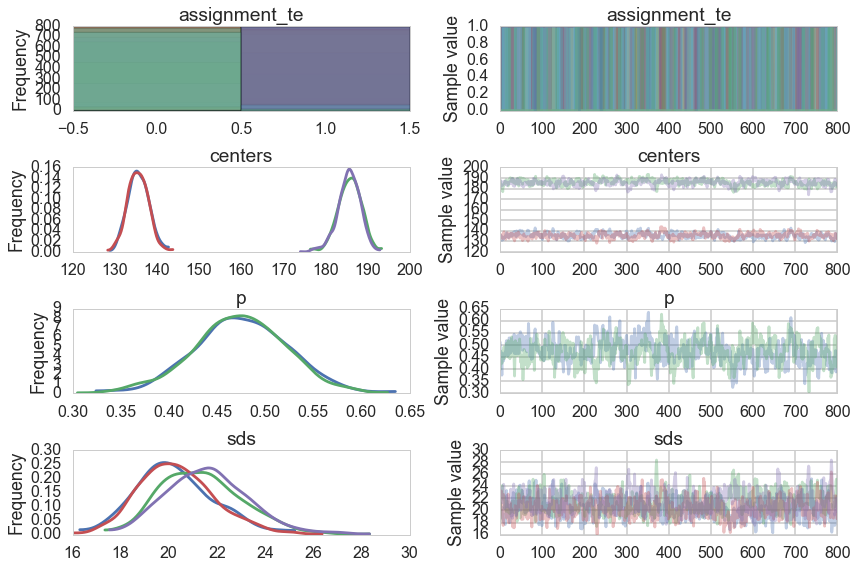

In [50]:
trace_cm2 = trace_cm2_full[2000::10]
pm.traceplot(trace_cm2);

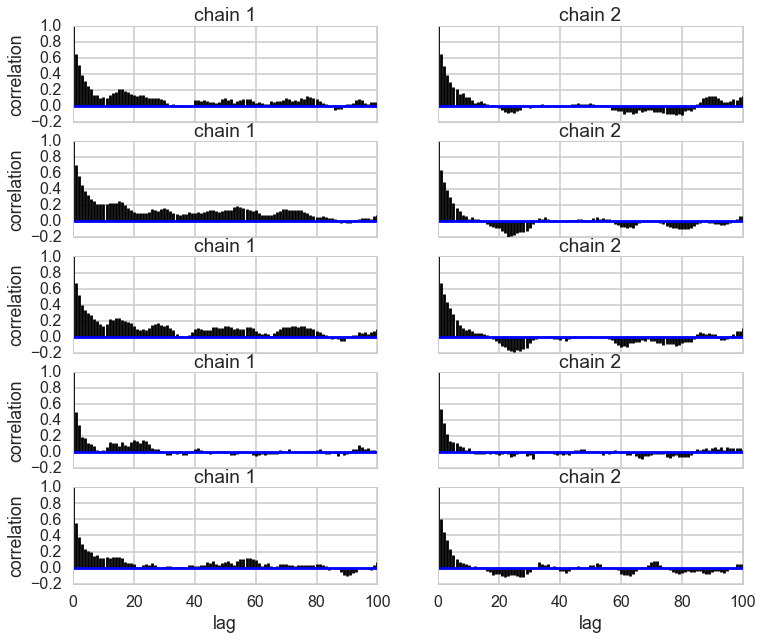

In [51]:
pm.autocorrplot(trace_cm2, varnames=['centers', 'p', 'sds']);

There is still quite a bit of autocorrelation and we might want to sample longer. But let us see how we did.

In [52]:
assign_trace = trace_cm2['assignment_te']

In [53]:
zpred2=1*(assign_trace.mean(axis=0) > 0.5)
confusion_matrix(zte, zpred2)

array([[211,  23],
       [ 17, 224]])

In [54]:
accuracy_score(zte, zpred2)

0.91578947368421049

The accuracy has improved just by having some additional terms in the likelihood!

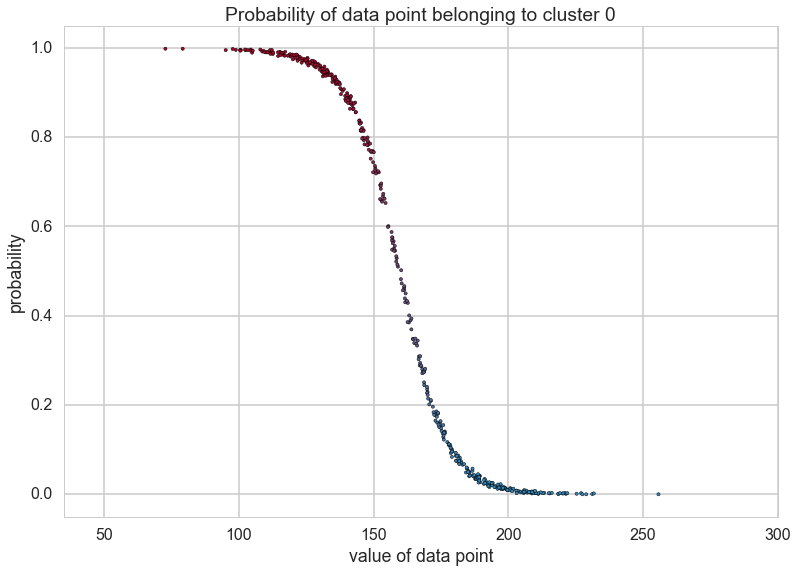

In [55]:

cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
plt.scatter(xte, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=10)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point")